# Two-Sample Hypothesis Testing and ANOVA

In this notebook, we extend hypothesis testing to comparisons between groups.

We cover:
- two-sample t-tests
- variance assumptions and Welch correction
- one-way ANOVA
- post-hoc testing

These methods answer the question:
**Do different groups come from the same population?**


### 🟦 Imports & Data

In [1]:
import sys
from pathlib import Path

# Get project root: notebooks/ → project/
PROJECT_ROOT = Path().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

print("Added to path:", PROJECT_ROOT)


Added to path: /home/arun/Documents/statistics-and-atmospheric-data/fundamentals_statistics/project


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

from src.data_generation import generate_student_dataset

sns.set(style="whitegrid")

df = generate_student_dataset(n=4000, random_state=42)


## 🟩 Part I: Two-Sample Testing: Research Question

Do **male and female students** have the same average exam score?

### 🟦 Hypotheses (Two-Sample t-test)


Let:
- $ \mu_M $ = mean score of male students  
- $ \mu_F $ = mean score of female students  

$$
H_0: \mu_M = \mu_F
$$

$$
H_1: \mu_M \neq \mu_F
$$

This is a **two-sided independent samples test**.


### 🟦 Assumptions of the Two-Sample t-Test

1. Independence of observations
2. Approximate normality within each group
3. Equality of variances (only for the classical t-test)

If assumption (3) fails, we use **Welch’s t-test**.

### 🟦 Group Separation

In [3]:
group_m = df[df.gender == "M"]["score"]
group_f = df[df.gender == "F"]["score"]

group_m.mean(), group_f.mean()

(np.float64(96.80062588322363), np.float64(97.39310159332925))

### 🟦 Variance Equality Test (Levene)

In [4]:
levene_stat, levene_p = stats.levene(group_m, group_f)
levene_stat, levene_p


(np.float64(13.174598315972585), np.float64(0.00028732069089755795))

### 🟦 Variance Test Interpretation

#### Variance Equality

- If $ p > 0.05 $: equal variances assumed
- If $ p \le 0.05 $: variances differ

To be conservative, we proceed with **Welch’s t-test**.

### 🟦 Mathematical Formulation (Welch t-test)

The test statistic is:

$$
t = \frac{\bar{x}_1 - \bar{x}_2}
{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
$$

Degrees of freedom are approximated by the
Welch–Satterthwaite equation.

### 🟦 Welch’s t-Test (SciPy)

In [5]:
t_stat, p_value = stats.ttest_ind(
    group_m,
    group_f,
    equal_var=False
)

t_stat, p_value


(np.float64(-3.6284266762752067), np.float64(0.00028875762145510027))

### 🟦 Conclusion (Two-Sample Test)

- The p-value indicates a statistically significant difference
- Mean scores differ between groups
- Practical significance will be assessed using effect size

At this stage, we conclude **a difference exists**, not how large it is.

## 🟩 Part II — One-Way ANOVA

### 🟦 ANOVA Research Question

Does the **teaching method** influence exam scores?

### 🟦 ANOVA Hypotheses

Let:
- $ \mu_A, \mu_B, \mu_C $ be mean scores for methods A, B, and C

$$
H_0: \mu_A = \mu_B = \mu_C
$$

$$
H_1: \text{At least one group mean differs}
$$

### 🟦 Why ANOVA? Why Not Multiple t-Tests?

Multiple pairwise t-tests inflate the **Type I error rate**.

ANOVA solves this by testing all group means simultaneously
while controlling the overall error rate.

### 🟦 Mathematical Formulation (ANOVA)

The F-statistic is defined as:

$$
F = \frac{MS_{\text{between}}}{MS_{\text{within}}}
$$

Where:
$$
MS_{\text{between}} = \frac{SS_{\text{between}}}{k - 1}
\quad
MS_{\text{within}} = \frac{SS_{\text{within}}}{N - k}
$$

Under $ H_0 $:

$$
F \sim F_{k-1, N-k}
$$

### 🟦 Visual Inspection

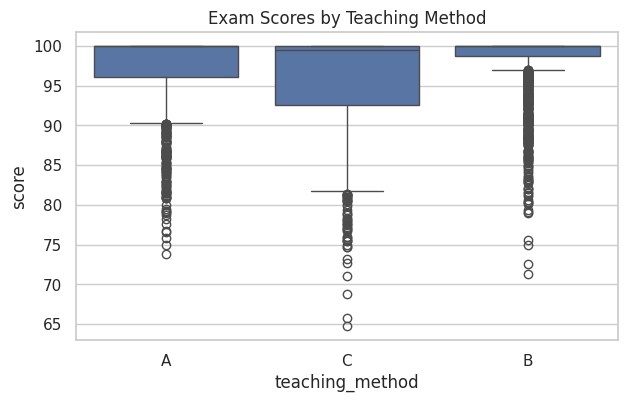

In [6]:
plt.figure(figsize=(7, 4))
sns.boxplot(x="teaching_method", y="score", data=df)
plt.title("Exam Scores by Teaching Method")
plt.show()


### 🟦 One-Way ANOVA (SciPy)

In [7]:
stats.f_oneway(
    df[df.teaching_method == "A"]["score"],
    df[df.teaching_method == "B"]["score"],
    df[df.teaching_method == "C"]["score"]
)


F_onewayResult(statistic=np.float64(86.71374551622138), pvalue=np.float64(1.3640071703574619e-37))

### 🟦 ANOVA via Statsmodels (Recommended)

In [8]:
anova_model = ols("score ~ C(teaching_method)", data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
C(teaching_method),4444.340556,2.0,86.713746,1.364007e-37
Residual,102429.142569,3997.0,NaN,NaN


### 🟦 ANOVA Interpretation

- The F-statistic is large
- The p-value is extremely small

We reject the null hypothesis:
**Teaching method has a statistically significant effect on exam scores.**

### 🟦 Post-hoc Testing Motivation

#### Why Post-hoc Tests?

ANOVA tells us **that a difference exists**, but not **where**.

Post-hoc tests identify which pairs of groups differ
while controlling for multiple comparisons.

### 🟦 Tukey HSD Post-hoc Test

In [9]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=df["score"],
    groups=df["teaching_method"],
    alpha=0.05
)

print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     A      B   0.9573   0.0  0.5068  1.4078   True
     A      C  -1.6004   0.0 -2.0867 -1.1142   True
     B      C  -2.5577   0.0 -3.0137 -2.1018   True
---------------------------------------------------


### 🟦 Post-hoc Interpretation

- Some teaching methods differ significantly
- Others may not
- The magnitude of differences will be quantified using effect size

This completes the group comparison analysis.

## Summary

In this notebook, we demonstrated:

- Two-sample hypothesis testing with variance diagnostics
- Welch’s t-test for robustness
- One-way ANOVA with mathematical foundation
- Post-hoc testing for detailed group comparisons

These methods generalize hypothesis testing beyond single populations.
